In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import cv2


In [2]:
DATASET_PATH= "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/"

# **READ THE DATAFRAME**

In [3]:
df = pd.read_csv(DATASET_PATH + "styles.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 1

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

     year   usage                             productDisplayName      image  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg  
5  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012.0  Ethnic               Fabindia Men Striped Green Shirt  30805.jpg  
7  2012.0  Casual                  Jealous 21 Women Purple Shirt  26960.jpg  
8  2012.0  Casual                       Puma Men Pack of 3 Socks  29114.jpg  
9  2016.0  Casual                         Skagen Men Black Watch  30039.jpg

# **VISUALIZATION OF DATA AND  PREPROCESSING**

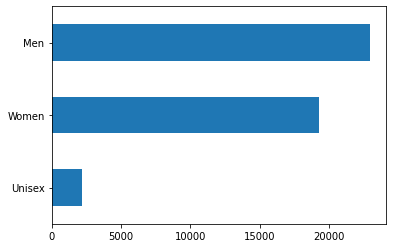

In [4]:
df['gender'] = df.gender.replace({'Girls': 'Women', 'Boys': 'Men'})
f = df.gender.value_counts().sort_values().plot(kind='barh')

In [5]:
df.gender.value_counts()

Men       22977
Women     19286
Unisex     2161
Name: gender, dtype: int64

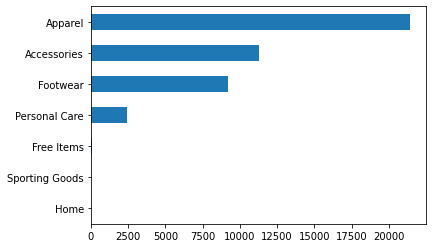

In [6]:
#df = df[df['masterCategory']=='Apparel']
f = df.masterCategory.value_counts().sort_values().plot(kind='barh')

In [7]:
fig = f.get_figure()
fig.savefig("output.png")

<AxesSubplot:xlabel='masterCategory', ylabel='count'>

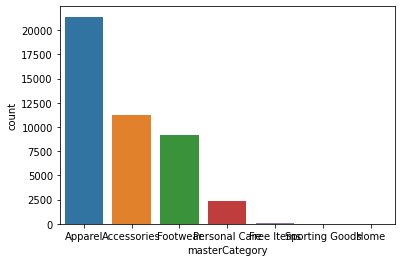

In [8]:
import seaborn as sns
sns.countplot(x ='masterCategory', data = df)

In [9]:
fig.savefig('Clustering.png')

<AxesSubplot:>

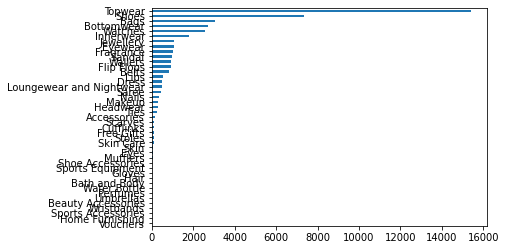

In [10]:
df  = df[(df['subCategory'] != 'Apparel Set') & (df['subCategory'] != 'Socks')]
df.subCategory.value_counts().sort_values().plot(kind='barh')

In [11]:
df = df.reset_index(drop=True)

In [12]:
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

# **LET'S VISUALIZE SOME RANDOM IMAGES**

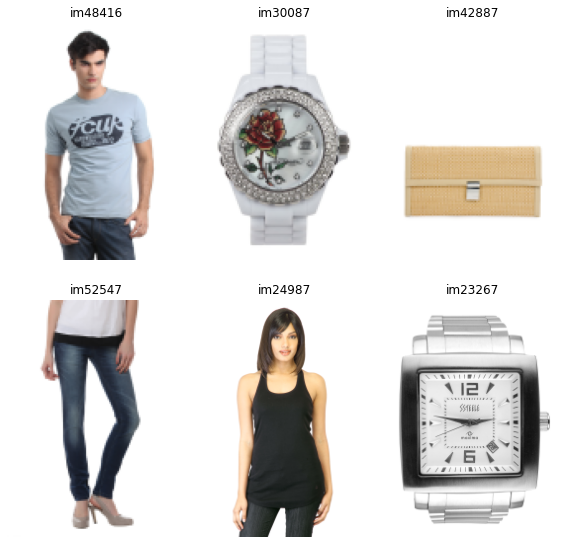

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(row['id']): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# **NOW LET'S USE RESNET TO GET IMAGE EMBEDDING**

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import Model

from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D

from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import time

In [ ]:
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

In [ ]:
def get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
        x   = image.img_to_array(img)
        x   = np.expand_dims(x, axis=0)
        x   = preprocess_input(x)
        return model.predict(x).reshape(-1)
    except:
        return [-1]*2048
    

In [ ]:
"""%%time
#import swifter
from tqdm import tqdm
tqdm.pandas()
# Parallel apply
map_embeddings = df['image'].progress_apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

df_embs.to_csv('embedding.csv')"""

**POST THIS POINT,I USE MY embedding.csv to run Kernel PCA, ISOMAP, TSNE. I run all of those on a different notebook on AWS Cluster with 196GB RAM. The resulting embeddings of 100 dimensions are read next**

In [18]:
df_new = pd.read_csv('../input/latestembedding/df_new.csv')
df_embed_new = pd.read_csv('../input/latestembedding/df_embs.csv')
df_embed_kpca = pd.read_csv('../input/latestembedding/df_embed_kpca.csv')
df_embed_iso100 = pd.read_csv('../input/latestembedding/isomap_100.csv')
df_embed_iso2 = pd.read_csv('../input/latestembedding/isomap_2.csv')
df_embed_pca = pd.read_csv('../input/latestembedding/df_embed_pca.csv')


In [19]:
#df_embed_safe = df_embed.copy()
del df_embed_new['Unnamed: 0']
del df_new['Unnamed: 0']

#df_embed_safe = df_embed.copy()
del df_embed_kpca['Unnamed: 0']
del df_embed_iso100['Unnamed: 0']
del df_embed_iso2['Unnamed: 0']
del df_embed_pca['Unnamed: 0']

# **Now first let's run recommendation on our original embeddings of 2048 dimensions**

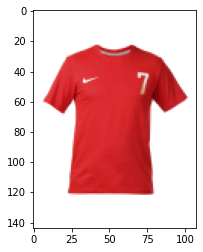

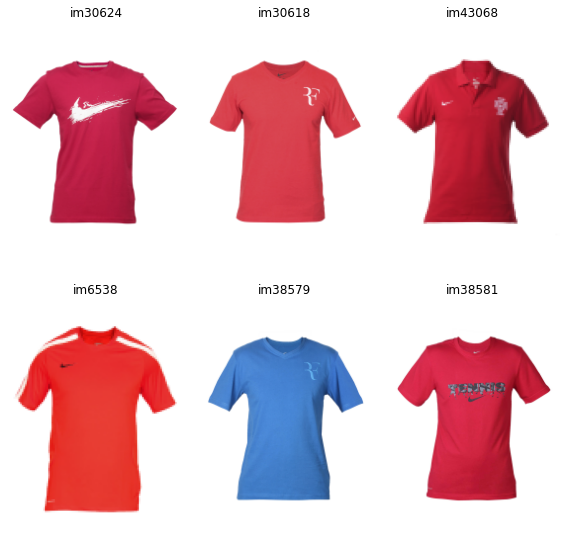

In [20]:
from tqdm import tqdm
tqdm.pandas()

ref_image_id = 44222

def recommend(df,df_embed,top = 6,image_id=9204):
    #print(image_id)
    #First we get the index of the element in the main datagrame and then retrieve it's embeddings
    
    index = df.index[df['id'] == image_id].tolist()[0]
    
    #print(index)
    image_embedding = df_embed.iloc[index]
    t1 = time.time()
    def cosin_sim(image_embed,x):
        return 1 - distance.cosine(image_embedding,x)
    
    #Find cosine similarity with all other images
    best_all = df_embed.apply(lambda x: cosin_sim(image_embedding, x),axis=1)
    t2=time.time()
    #print(str(t2-t1))
    best_all = best_all.sort_values(ascending=False)
    
    #Get top 5, we ignore index 0 and it is the cosine similarity with itself
    top_n = best_all[1:top+1]
    
    #Get the index of top 5 
    best_image_index = top_n.index.to_list()
    
    def get_image_id(ix):
        #print(ix)
        return df['id'].loc[[ix]].values[0]
    
    #Now we get the image ids of top 5 images
    best_image = list(map(get_image_id,best_image_index))

    
    return best_image

best_index = recommend(df_new,df_embed_new,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_index}
plot_figures(figures, 2, 3)
    

# **NOW I'LL TRY PCA EMBEDDINGS**

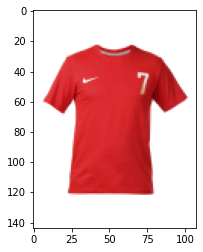

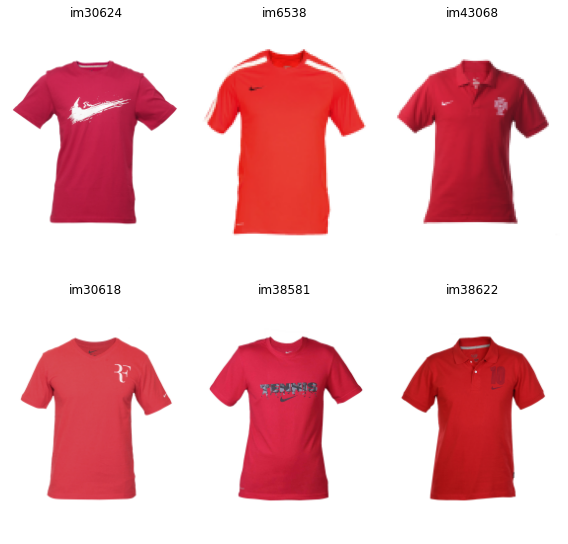

In [21]:
ref_image_id = 44222

best_index = recommend(df_new,df_embed_pca,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_index}
plot_figures(figures, 2, 3)
    

# **NOW LET'S RUN RECOMMENDATIONS ON KERNEL PCA EMBEDDINGS TO COMPARE. WE WILL SEE, THE EMBEDDINGS OF KERNEL PCA GIVE A BETTER RESULT**

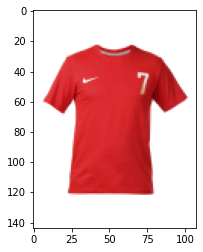

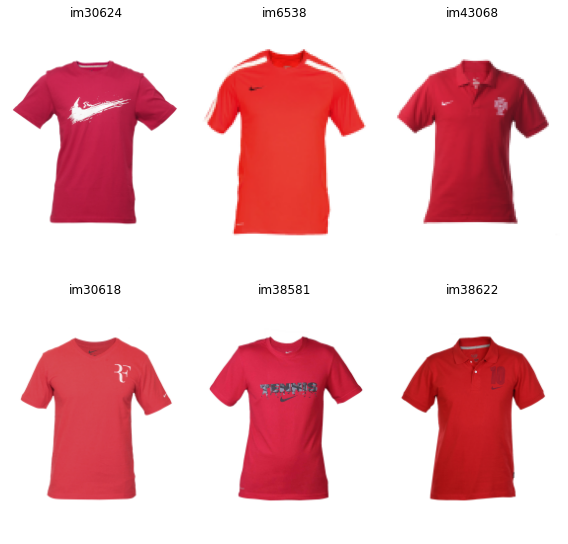

In [22]:
ref_image_id = 44222

best_index = recommend(df_new,df_embed_kpca,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_index}
plot_figures(figures, 2, 3)
    

# **NOW LET'S RUN RECOMMENDATION FOR IS0MAP100**

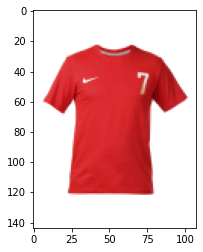

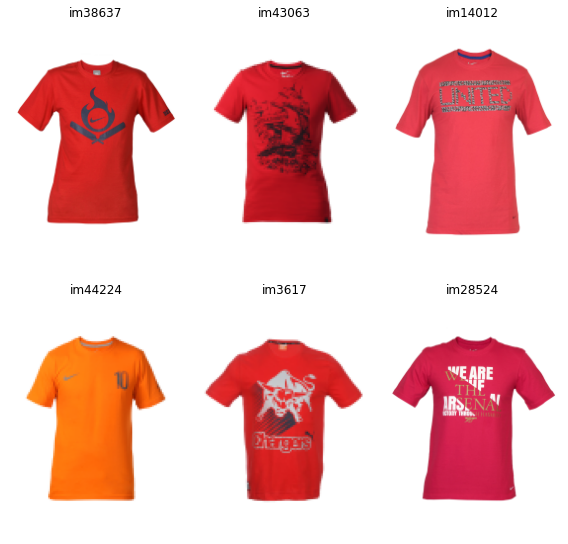

In [23]:
ref_image_id = 44222

best_index = recommend(df_new,df_embed_iso100,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_index}
plot_figures(figures, 2, 3)
    

# **NOW LET'S RUN RECOMMENDATION FOR IS0MAP2. HERE EACH IMAGE HAS ONLY 2 EMBEDDING DIMENSIONS**

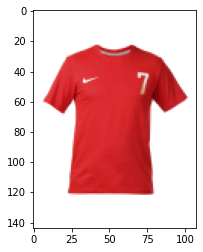

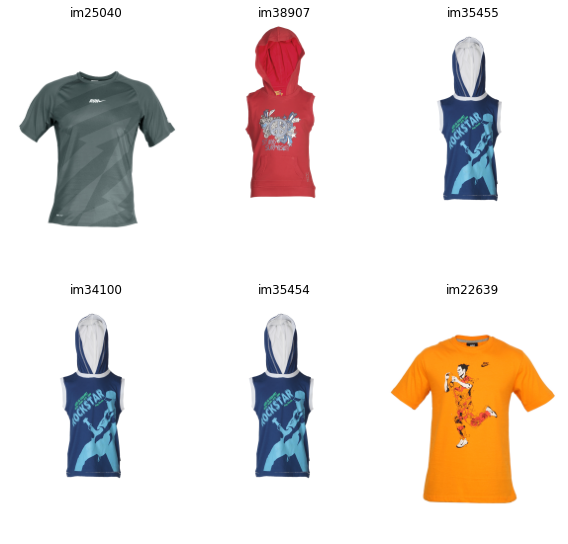

In [24]:
ref_image_id = 44222

best_index = recommend(df_new,df_embed_iso2,6,ref_image_id)
#SHow the ref image
plt.imshow(cv2.cvtColor(load_image(str(ref_image_id)+'.jpg'), cv2.COLOR_BGR2RGB))  

#Show all other images
figures = {'im'+str(i): load_image(str(i)+'.jpg') for i in best_index}
plot_figures(figures, 2, 3)
    

# **NOW I WILL SAMPLE 100 IMAGES OF EACH CATEGORY footwear, apparel, accessories**

In [25]:
df_footwear = df_new[df_new['masterCategory']=='Footwear']
df_apparel = df_new[df_new['masterCategory']=='Apparel']
df_accessories = df_new[df_new['masterCategory']=='Accessories']
df_footwear_sample = df_footwear.sample(n = 100)
df_apparel_sample = df_apparel.sample(n = 100)
df_accessories_sample = df_accessories.sample(n = 100)

# **NOW I WILL CALCULATE PRECISION ON THIS**

In [26]:
def precision_calculator(df,df_sample,df_embed,top):

    all_correct = []

    for index, row in df_sample.iterrows():

        ref_image_id = row['id']
        best_index = recommend(df,df_embed,top,ref_image_id)

        ref_gender = row['gender']
        ref_masterCategory = row['masterCategory']
        ref_subCategory = row['subCategory']
        ref_articleType = row['articleType']
        ref_baseColour = row['baseColour']
        
        correct = 0.0
        for item in best_index:
            curr_img = df[df['id']==item]

            """if((curr_img['gender'].values[0] is ref_gender)  
               & (curr_img['masterCategory'].values[0] is ref_masterCategory) 
               & (curr_img['subCategory'].values[0] is ref_subCategory)   
               & (curr_img['articleType'].values[0] is ref_articleType)):

                correct+=1"""

            if(curr_img['gender'].values[0] is ref_gender):
                correct+=0.2
            if(curr_img['masterCategory'].values[0] is ref_masterCategory):
                correct+=0.2
            if(curr_img['subCategory'].values[0] is ref_subCategory):
                correct+=0.2
            if(curr_img['articleType'].values[0] is ref_articleType):
                 correct+=0.2
            if(curr_img['baseColour'].values[0] is ref_baseColour):
                 correct+=0.2
                    
        all_correct.append(correct/6) 

    return sum(all_correct)/len(all_correct)

pAtk_footwear = precision_calculator(df_new,df_footwear_sample,df_embed_kpca,6)
pAtk_apparel = precision_calculator(df_new,df_apparel_sample,df_embed_kpca,6)
pAtk_accessories = precision_calculator(df_new,df_accessories_sample,df_embed_kpca,6)
pAtk_footwear, pAtk_apparel, pAtk_accessories

(0.769, 0.7993333333333332, 0.8230000000000001)

In [27]:
pAtk_footwear = precision_calculator(df_new,df_footwear_sample,df_embed_iso100,6)
pAtk_apparel = precision_calculator(df_new,df_apparel_sample,df_embed_iso100,6)
pAtk_accessories = precision_calculator(df_new,df_accessories_sample,df_embed_iso100,6)
pAtk_footwear, pAtk_apparel, pAtk_accessories

(0.7386666666666669, 0.7723333333333325, 0.7939999999999999)

In [28]:
pAtk_footwear = precision_calculator(df_new,df_footwear_sample,df_embed_pca,6)
pAtk_apparel = precision_calculator(df_new,df_apparel_sample,df_embed_pca,6)
pAtk_accessories = precision_calculator(df_new,df_accessories_sample,df_embed_pca,6)
pAtk_footwear, pAtk_apparel, pAtk_accessories

(0.769, 0.7993333333333332, 0.8230000000000001)

**NOW LET'S VISUALIZE THE RESULTS USING TSNE AND UMAP**

In [29]:
from sklearn.manifold import TSNE
import time
import seaborn as sns
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed_new)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [30]:
df_new['tsne-2d-one'] = tsne_results[:,0]
df_new['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

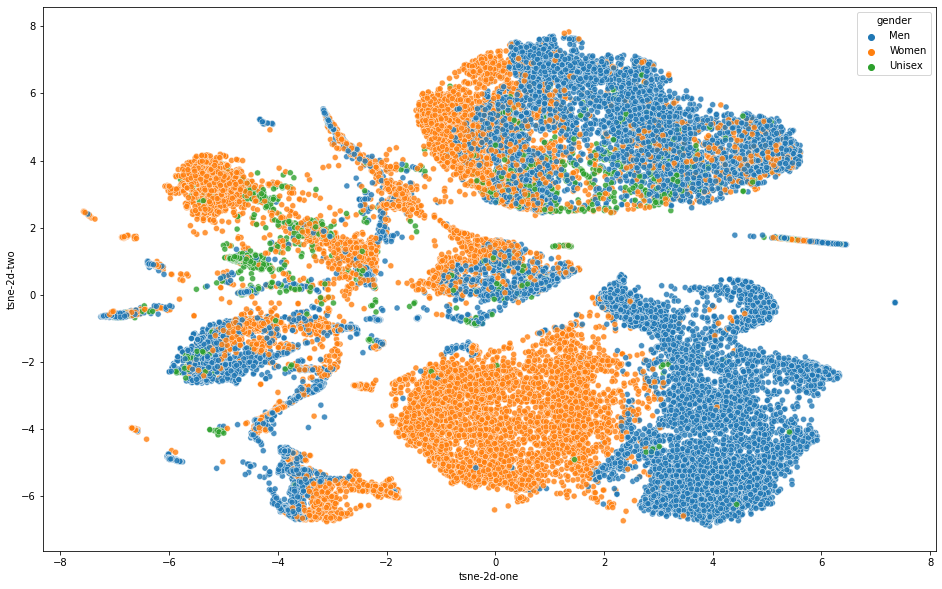

In [31]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="gender",
                data=df_new,
                legend="full",
                alpha=0.8)

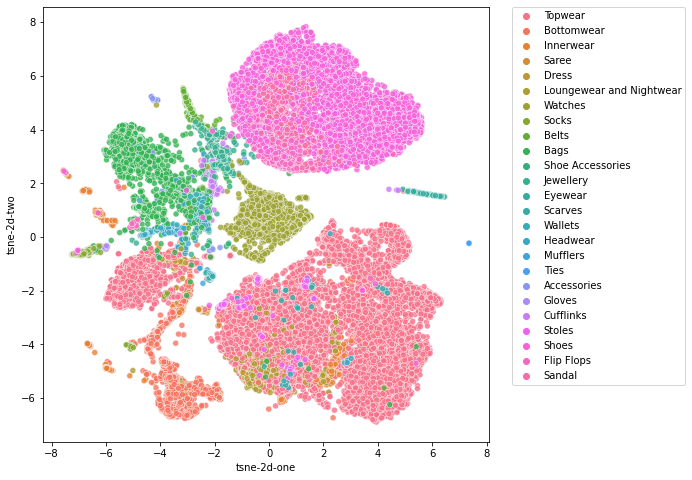

In [32]:
plt.figure(figsize=(8,8))
a = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df_new,
                legend="full",
                alpha=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig = a.get_figure()
fig.savefig('as.png') 

In [33]:
from umap import UMAP
plt.figure(figsize=(20,15))
model = UMAP(n_neighbors = 15, min_dist = 0.1, n_components = 2, verbose = True)
umap = model.fit_transform(df_embed_new)

UMAP( verbose=True)
Wed May  4 14:57:27 2022 Construct fuzzy simplicial set
Wed May  4 14:57:27 2022 Finding Nearest Neighbors
Wed May  4 14:57:27 2022 Building RP forest with 15 trees
Wed May  4 14:57:36 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Wed May  4 14:57:58 2022 Finished Nearest Neighbor Search
Wed May  4 14:58:01 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed May  4 14:58:28 2022 Finished embedding


<Figure size 1440x1080 with 0 Axes>

In [34]:
df_new['umap-2d-one'] = umap[:,0]
df_new['umap-2d-two'] = umap[:,1]

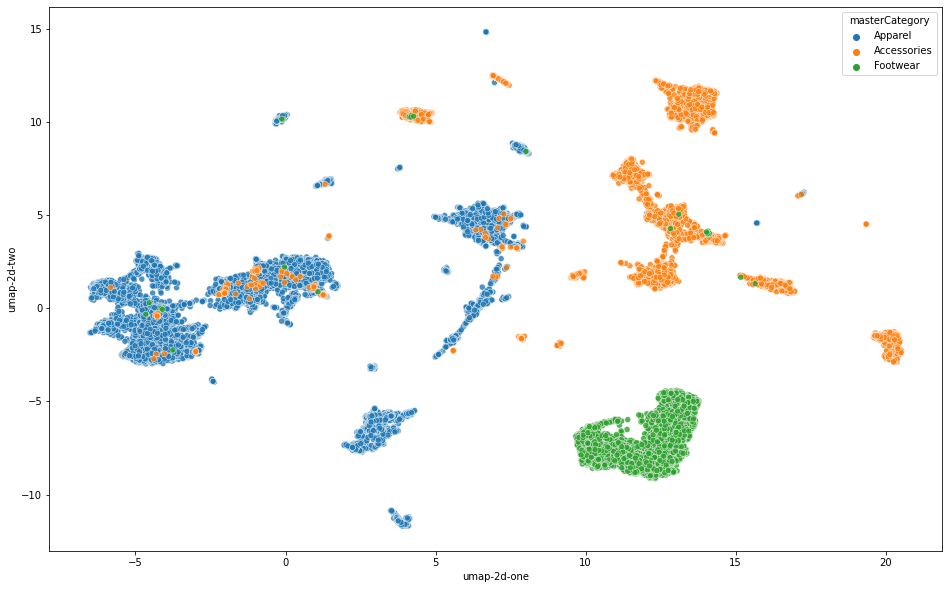

In [35]:
plt.figure(figsize=(16,10))
a = sns.scatterplot(x="umap-2d-one", y="umap-2d-two",
                hue="masterCategory",
                data=df_new,
                legend="full",
                alpha=0.8)


In [36]:
fig = a.get_figure()
fig.savefig("out.png") 

UMAP(min_dist=0.25, verbose=True)
Wed May  4 15:24:05 2022 Construct fuzzy simplicial set
Wed May  4 15:24:05 2022 Finding Nearest Neighbors
Wed May  4 15:24:05 2022 Building RP forest with 15 trees
Wed May  4 15:24:06 2022 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Wed May  4 15:24:08 2022 Finished Nearest Neighbor Search
Wed May  4 15:24:09 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Wed May  4 15:24:37 2022 Finished embedding


<Figure size 1440x1080 with 0 Axes>

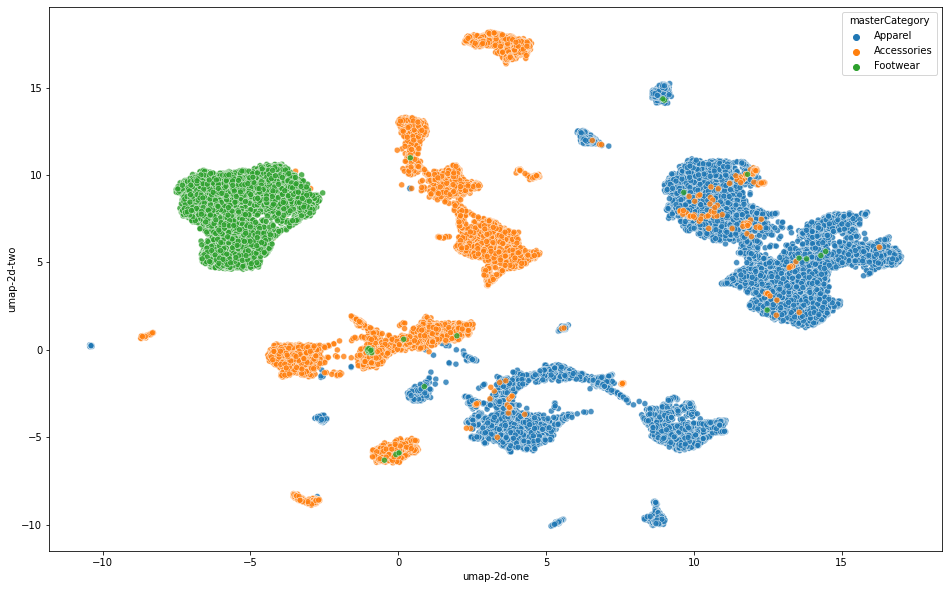

In [38]:
from umap import UMAP
plt.figure(figsize=(20,15))
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(df_embed_pca)

df_new['umap-2d-one'] = umap[:,0]
df_new['umap-2d-two'] = umap[:,1]

plt.figure(figsize=(16,10))
a = sns.scatterplot(x="umap-2d-one", y="umap-2d-two",
                hue="masterCategory",
                data=df_new,
                legend="full",
                alpha=0.8)

In [39]:
import plotly.express as px

fig = px.scatter(df_new, x="umap-2d-one", y="umap-2d-two", color = "masterCategory",
                 hover_name="gender", hover_data=["articleType","season"])

fig.show()